In [1]:
import GA
import smc_abc
import smc_abc_ours
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import pyabc
import time
import matplotlib.pyplot as plt
from scipy import optimize
import pickle

In [2]:
def compare_params_bar(true_params,popt, ga, smcabc_lit,smcabc_ours):
    cols = list(true_params.keys())
    cols.sort()
    pos = np.arange(len(true_params))*6
    
    
    plt.figure(figsize=(6,3))
    plt.bar(pos,[true_params[col] for col in cols],label='True',zorder=1)
    plt.bar(pos+1,popt,label='LSQ',zorder=1)
    
    ## GA
    plt.bar(pos+2,
            [np.median([item.genes[col] for item in ga.population]) for col in cols],
            label='GA',zorder=1)
    s = len(ga.population)
    for i,col in enumerate(cols):
        plt.scatter([pos[i]]*s+np.random.normal(2,0.05,size=s),
                    [item.genes[col] for item in ga.population],
                    color='gray',alpha=0.5,s=5,zorder=2)
        
        
    ## SMC-ABC classic
    df,w = smcabc_lit.history.get_distribution()
    df = df.loc[:,cols]
    plt.bar(pos+3,[np.median(df[col]) for col in cols],label='Classic SMC-ABC',zorder=1)
    
    for i,col in enumerate(cols):
        plt.scatter([pos[i]]*df.shape[0]+np.random.normal(3,0.05,size=df.shape[0]),
                    df[col],color='gray',alpha=0.5,s=5,zorder=2)
        
    ## This work
    
    plt.bar(pos+4,[np.median([item[col] for item in smcabc_ours.population]) for col in cols],label='This work',zorder=1)
    
    s = len(smcabc_ours.population)
    for i,col in enumerate(cols):
        plt.scatter([pos[i]]*s+np.random.normal(4,0.05,size=s),
                    [item[col] for item in smcabc_ours.population],
                    color='gray',alpha=0.5,s=5,zorder=2)
    
    
    plt.legend(bbox_to_anchor=(1.01,1))
    plt.xlabel('Parameters')
    plt.ylabel('Values')
    plt.xticks([2,8],[r'$\beta$$_{1}$',r'$\beta$$_{2}$'])
    plt.show()

In [3]:
def compare_params_hist(true_params,popt, ga, smcabc_lit,smcabc_ours,outname=None):
    cols = list(true_params.keys())
    cols.sort()
    pos = np.arange(len(true_params))*6
    df,w = smcabc_lit.history.get_distribution()
    
    plt.figure(figsize=(8,3))
    for i,col in enumerate(cols):
        plt.subplot(1,len(true_params),i+1)
        plt.plot([true_params[col]]*2,[0,25],label='True',color='k')
        #plt.hist(true_params[col],label='True',color='k')
        plt.plot([popt[i]]*2,[0,25],label='LSQ',color='r')
        
        #plt.hist(popt[i],label='LSQ',alpha=0.5)
        plt.hist([item.genes[col] for item in ga.population],label='GA',alpha=0.5)
        plt.hist(df[col],label='Classic SMC-ABC',alpha=0.5)
        plt.hist([item[col] for item in smcabc_ours.population],label='This work',alpha=0.5)
    
    labels = [r'$\beta$$_{1}$',r'$\beta$$_{2}$']
    for i in range(len(cols)):
        plt.subplot(1,len(true_params),i+1)
        if i==1: plt.legend(bbox_to_anchor=(1.01,1))
        plt.xlabel(labels[i])
        plt.ylabel('Counts')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

### Case 1: y=2x1+3x2

In [4]:
def case1():
    def linear_model(param):
     # {'p0':,'p1':,...}
        p = np.array([param['p{0}'.format(i)] for i in range(len(param))])

        res = np.dot(x_exp,np.transpose(p))

        return {'data': res}
    
    def distance(x,y):
        return MSE(x['data'],y['data'])
    
    def residual_linear_model(p):
        return y_exp['data']-linear_model({'p{0}'.format(i):p[i] for i in range(len(p))})['data']

    param_num = 2
    population_size = 100
    training_samples =  100
    max_ite = 1000
    
    priors1 = pyabc.Distribution(**{'p{0}'.format(i):pyabc.RV('norm',5,3) for i in range(param_num)})
    priors2 = {'p{0}'.format(i):smc_abc_ours.RV('normal',5,3) for i in range(param_num)}
    
    np.random.seed(2)
    x_exp       = np.random.normal(size=(training_samples,param_num))
    true_params = {'p0':2,'p1':3}
    y_true       = linear_model(true_params)
    y_exp = dict()
    y_exp['data']= y_true['data'] + np.random.normal(scale=2,size=training_samples)
    print('MSE best:', MSE(y_exp['data'],y_true['data']))
    min_dist = MSE(y_exp['data'],y_true['data'])
    
    np.random.seed()
    plt.scatter(y_true['data'],y_exp['data'])
    plt.xlabel('True')
    plt.ylabel('True+Noise')
    plt.show()
    
    popt, _= optimize.leastsq(residual_linear_model, [5,5])
    print('Leastsq:',popt)
    print('Leastsq MSE:',distance(y_exp,linear_model({'p{0}'.format(i):popt[i] for i in range(len(popt))})))
    
    
    ga = GA.GA(linear_model,
         distance,
         y_exp,
         priors2,
         population_size=population_size, 
         mutation_rate=0.1,
         mutation_scale=0.1,
         max_ite=max_ite,
         min_dist=min_dist
         )
    t0 = time.time()
    ga.run()
    print('GA time:',time.time()-t0)
    
    GA.plot_training_curve(ga,'../figures/case1_ga.pdf')
    GA.plot_params_bar(true_params,ga)
    
    
    
    smcabc_lit = smc_abc.smc_abc(linear_model,
               distance,
               y_exp,
               priors1,
               population_size,
               min_dist=min_dist,
               max_ite=max_ite)
    t0 = time.time()
    smcabc_lit.run()
    print('SMC-ABC classical:',time.time()-t0)
    smc_abc.plot_params_bar(smcabc_lit,true_params)
    smc_abc.plot_training_curve(smcabc_lit,'../figures/case1_smc_abc_classic.pdf')


    smcabc_ours = smc_abc_ours.smc_abc_ours(linear_model,
                   priors2,
                   min_dist,
                   population_size,
                   distance_function=distance,
                   Yobs=y_exp,
                   max_iter=max_ite,
                   cores=4,
                   generation_size=population_size)
    
    t0=time.time()
    smcabc_ours.run_simulation()
    print('SMC-ABC this work:',time.time()-t0)
    
    smc_abc_ours.plot_params_bar(true_params,smcabc_ours)
    smc_abc_ours.plot_training_curve(smcabc_ours,'../figures/case1_smc_abc_this_work.pdf')
    
    return true_params,popt, ga, smcabc_lit,smcabc_ours

MSE best: 3.857373658659171


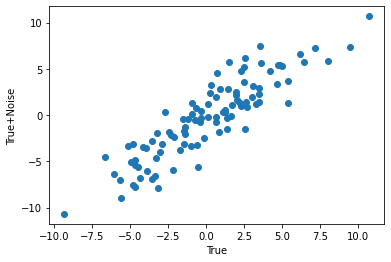

Leastsq: [2.11396422 3.04925933]
Leastsq MSE: 3.839072467762977
t2: 24.112239589605352
t3: 20.044480789985762
t4: 13.837470144440172
t5: 12.344771827371414
t6: 12.479858996970716
t7: 11.329550938008792
t8: 9.909401460744967
t9: 8.871109646966044
t10: 6.054598852102239
t11: 5.481931914888108
t12: 5.310367952505294
t13: 5.054141066406888
t14: 5.0152796497724905
t15: 4.6886328482292985
t16: 4.498501542418543
t17: 4.3984969235037354
t18: 4.152194980650029
t19: 4.118960626149121
t20: 4.038939902414339
t21: 4.010871452311975
t22: 3.9956813707146557
t23: 3.9965630100388374
t24: 3.982235518142793
t25: 3.972872105642999
t26: 3.951868160054803
t27: 3.9382832461900583
t28: 3.912156949021653
t29: 3.8895822435870464
t30: 3.8632240362005206
t31: 3.850517219515484
GA time: 1.8216145038604736


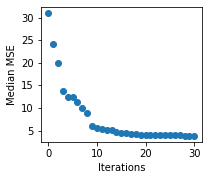

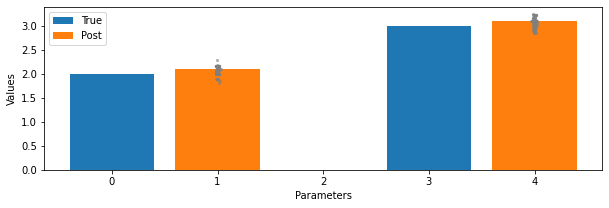

INFO:History:Start <ABCSMC(id=28, start_time=2020-09-30 10:03:27.811465, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 32.64678956680234
INFO:ABC:t: 0, eps: 32.64678956680234.
INFO:ABC:Acceptance rate: 100 / 186 = 5.3763e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 13.781763340381197.
INFO:ABC:Acceptance rate: 100 / 230 = 4.3478e-01, ESS=9.8212e+01.
INFO:ABC:t: 2, eps: 9.352597995090889.
INFO:ABC:Acceptance rate: 100 / 211 = 4.7393e-01, ESS=9.6381e+01.
INFO:ABC:t: 3, eps: 6.007347643069979.
INFO:ABC:Acceptance rate: 100 / 241 = 4.1494e-01, ESS=9.6176e+01.
INFO:ABC:t: 4, eps: 4.914130343609749.
INFO:ABC:Acceptance rate: 100 / 185 = 5.4054e-01, ESS=9.7417e+01.
INFO:ABC:t: 5, eps: 4.415349533341489.
INFO:ABC:Acceptance rate: 100 / 181 = 5.5249e-01, ESS=9.5572e+01.
INFO:ABC:t: 6, eps: 4.113810088066761.
INFO:ABC:Acceptance rate: 100 / 254 = 3.9370e-01, ESS=9.4501e+01.
INFO:ABC:t: 7, eps: 3.95370814452716.
INFO:ABC:Acceptance rate: 100 / 238 = 4.2017e-0

SMC-ABC classical: 11.069047451019287


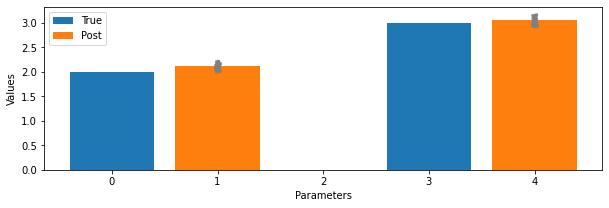

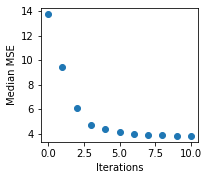

updating population
t1: epsilon= 30.14670808368891
Updating prior
updating population
t2: epsilon= 14.993096615290273
Updating prior
updating population
t3: epsilon= 7.504450567201575
Updating prior
updating population
t4: epsilon= 5.256143343111117
Updating prior
updating population
t5: epsilon= 4.411807898813816
Updating prior
updating population
t6: epsilon= 4.048273702811692
Updating prior
updating population
t7: epsilon= 3.919968102564142
Updating prior
updating population
t8: epsilon= 3.8678195541052984
Updating prior
updating population
t9: epsilon= 3.8531606952825443
Updating prior
SMC-ABC this work: 12.77736783027649


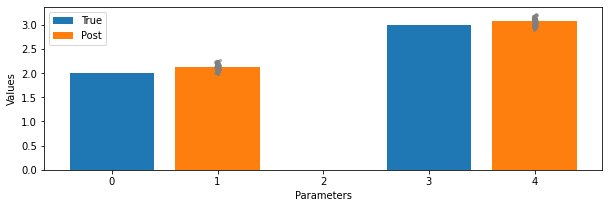

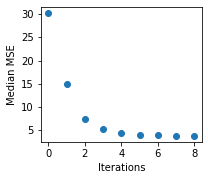

In [5]:
true_params1, popt1, ga1, smcabc_lit1,smc_abc_ours1 = case1()

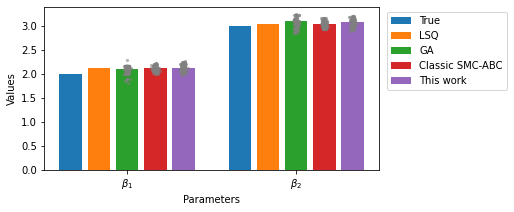

In [6]:
compare_params_bar(true_params1, popt1, ga1, smcabc_lit1,smc_abc_ours1)

/cephyr/users/gangl/Vera/Tools/my_python3_vera/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


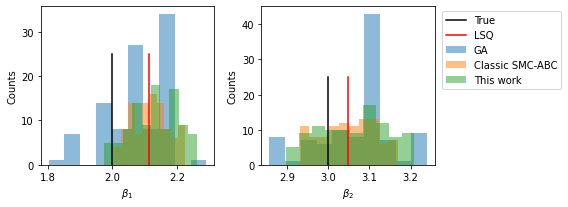

In [7]:
compare_params_hist(true_params1, popt1, ga1, smcabc_lit1,smc_abc_ours1,'../figures/case1_p_dist.pdf')